In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
tf.__version__

'1.15.0'

In [3]:
def MinMaxScaler(data):
    denom=np.max(data,0)-np.min(data,0)
    nume=data-np.min(data,0)
    return nume/denom
    #정규화

In [4]:
xy=np.loadtxt("data-02-stock_daily.csv", delimiter=",")
xy=xy[::-1] #역순으로 저장

In [5]:
xy

array([[5.68002570e+02, 5.68002570e+02, 5.52922516e+02, 1.31000000e+04,
        5.58462551e+02],
       [5.61202549e+02, 5.66432590e+02, 5.58672539e+02, 4.12000000e+04,
        5.59992565e+02],
       [5.66892592e+02, 5.67002574e+02, 5.56932537e+02, 1.08000000e+04,
        5.56972503e+02],
       ...,
       [8.19929993e+02, 8.24400024e+02, 8.18979980e+02, 1.28170000e+06,
        8.24159973e+02],
       [8.23020020e+02, 8.28070007e+02, 8.21655029e+02, 1.59780000e+06,
        8.28070007e+02],
       [8.28659973e+02, 8.33450012e+02, 8.28349976e+02, 1.24770000e+06,
        8.31659973e+02]])

In [6]:
# d=np.array([1,2,3,4])
# d[::-1]

In [7]:
seqLength=7 #window size
dataDim=5 #시가,종가,...거래량 5개 컬럼
hiddenDim=10
outputDim=1
lr=0.01
iterations=500

In [8]:
trainSize=int(len(xy)*0.7)
trainSet=xy[0:trainSize] #0:499
testSet=xy[trainSize-seqLength:]#493:499->500

In [9]:
trainSet=MinMaxScaler(trainSet)
testSet=MinMaxScaler(testSet)

In [10]:
trainSet.shape #(512,5)
testSet.shape #(227,5)
trainSet

array([[2.53065031e-01, 2.45070970e-01, 2.33983036e-01, 4.66075110e-04,
        2.32039560e-01],
       [2.29604366e-01, 2.39728936e-01, 2.54567513e-01, 2.98467330e-03,
        2.37426028e-01],
       [2.49235510e-01, 2.41668371e-01, 2.48338489e-01, 2.59926504e-04,
        2.26793794e-01],
       ...,
       [8.39570954e-01, 8.39838973e-01, 8.87125814e-01, 1.00779780e-01,
        8.63403284e-01],
       [8.31877329e-01, 8.51543969e-01, 8.87806005e-01, 9.37348750e-02,
        8.91180355e-01],
       [8.64998078e-01, 8.54129989e-01, 8.90383640e-01, 1.29541992e-01,
        8.72134355e-01]])

In [11]:
def buildDataSet(timeSeries, seqLength):
    xdata=[]
    ydata=[]
    for i in range(0, len(timeSeries)-seqLength):
        tx=timeSeries[i:i+seqLength,:]
        ty=timeSeries[i+seqLength,[-1]]
        xdata.append(tx)
        ydata.append(ty)
    return np.array(xdata), np.array(ydata)
    

In [12]:
trainX, trainY=buildDataSet(trainSet, seqLength)
testX, testY=buildDataSet(testSet, seqLength)

In [13]:
tf.__version__

'1.15.0'

In [14]:
trainY.shape

(505, 1)

In [15]:
trainX.shape #(505,7,5)
#505개 샘플, 7(일주일), 5(5개 컬럼)
testX.shape #(220, 7, 5)

(220, 7, 5)

In [16]:
x=tf.placeholder(tf.float32, [None, seqLength, dataDim])
y=tf.placeholder(tf.float32, [None, 1])

In [17]:
cell=tf.contrib.rnn.BasicLSTMCell(
    num_units=hiddenDim, 
    state_is_tuple=True,
    activation=tf.tanh
    #([1,2],[3,4])
    #is_Tuple=True => 튜플 = ([1,2],[3,4])
    #         False => 텐서 = [1,2,3,4]
)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.


In [18]:
outputs, _states=tf.nn.dynamic_rnn(cell, x, dtype=tf.float32)
yhat=tf.contrib.layers.fully_connected(outputs[:,-1],
                                       outputDim, activation_fn=None)


Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Please use `layer.__call__` method instead.


In [19]:
loss= tf.reduce_mean(tf.square(yhat-y))
opt=tf.train.AdamOptimizer(lr)
train=opt.minimize(loss)

In [20]:
#rmse
targets=tf.placeholder(tf.float32, [None,1])
predictions=tf.placeholder(tf.float32, [None,1])
rmse=tf.sqrt(tf.reduce_mean(tf.square(targets-predictions)))

In [21]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(iterations):
        _,cv=sess.run([train, loss], feed_dict={
            x:trainX, y:trainY
        })
        print("step:{} loss:{}".format(i, cv))
    testPredict=sess.run(yhat, feed_dict={x:testX})
    rmsev=sess.run(rmse, feed_dict={
        targets:testY,
        predictions:testPredict
    })
    print("rmse value: {}".format(rmsev))
    
        

step:0 loss:0.19014029204845428
step:1 loss:0.09835713356733322
step:2 loss:0.04100079461932182
step:3 loss:0.01663145050406456
step:4 loss:0.019452497363090515
step:5 loss:0.034012749791145325
step:6 loss:0.041851818561553955
step:7 loss:0.038686711341142654
step:8 loss:0.029219092801213264
step:9 loss:0.01889427937567234
step:10 loss:0.011203918606042862
step:11 loss:0.007419103290885687
step:12 loss:0.007111218757927418
step:13 loss:0.008916806429624557
step:14 loss:0.01127538550645113
step:15 loss:0.012945858761668205
step:16 loss:0.013261254876852036
step:17 loss:0.012152709998190403
step:18 loss:0.010004756972193718
step:19 loss:0.0074392808601260185
step:20 loss:0.005105411168187857
step:21 loss:0.0035080055240541697
step:22 loss:0.0028880436439067125
step:23 loss:0.0031734220683574677
step:24 loss:0.004021889995783567
step:25 loss:0.004957151599228382
step:26 loss:0.00555401248857379
step:27 loss:0.005591420456767082
step:28 loss:0.005104041192680597
step:29 loss:0.004321637563

step:254 loss:0.001646558870561421
step:255 loss:0.0016439225291833282
step:256 loss:0.0016413001576438546
step:257 loss:0.0016386917559430003
step:258 loss:0.0016360967420041561
step:259 loss:0.0016335147665813565
step:260 loss:0.0016309453640133142
step:261 loss:0.0016283888835459948
step:262 loss:0.0016258439281955361
step:263 loss:0.0016233108472079039
step:264 loss:0.0016207901062443852
step:265 loss:0.001618280541151762
step:266 loss:0.0016157816862687469
step:267 loss:0.0016132942400872707
step:268 loss:0.0016108178533613682
step:269 loss:0.0016083515947684646
step:270 loss:0.001605895347893238
step:271 loss:0.0016034499276429415
step:272 loss:0.0016010139370337129
step:273 loss:0.001598588190972805
step:274 loss:0.0015961721073836088
step:275 loss:0.0015937653370201588
step:276 loss:0.001591367763467133
step:277 loss:0.001588979852385819
step:278 loss:0.0015866007888689637
step:279 loss:0.0015842310385778546
step:280 loss:0.0015818699030205607
step:281 loss:0.001579517498612403

step:486 loss:0.0012608710676431656
step:487 loss:0.001260067685507238
step:488 loss:0.0012592703569680452
step:489 loss:0.001258479431271553
step:490 loss:0.001257694442756474
step:491 loss:0.0012569149257615209
step:492 loss:0.0012561416951939464
step:493 loss:0.0012553741689771414
step:494 loss:0.0012546125799417496
step:495 loss:0.0012538565788418055
step:496 loss:0.00125310686416924
step:497 loss:0.0012523625046014786
step:498 loss:0.0012516235001385212
step:499 loss:0.0012508903164416552
rmse value: 0.04809032008051872


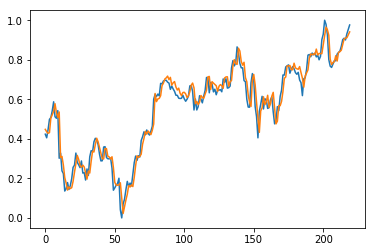

In [22]:
plt.plot(testY)
plt.plot(testPredict)
plt.show()

In [23]:
### 연습문제

In [24]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [43]:
def MinMaxScaler(data):
    denom=np.max(data,0)-np.min(data,0)
    nume=data-np.min(data,0)
    return nume/denom
#정규화

In [44]:
xy=pd.read_csv("C:/Users/student/Downloads/Python_JP/삼성전자주가.csv",encoding='ANSI')
xy=xy[::-1]

In [45]:
xy

,일자,시가,고가,저가,종가,거래량
9287,19850104,130,130,129,129,111764
9286,19850105,129,129,128,128,108496
9285,19850107,129,130,128,129,771895
9284,19850108,129,129,127,127,845098
9283,19850109,126,126,122,123,324836
...,...,...,...,...,...,...
4,20191230,56200,56600,55700,55800,8356767
3,20200102,55500,56000,55000,55200,12993228
2,20200103,56000,56600,54900,55500,15422255
1,20200106,54900,55600,54600,55500,10278951


In [46]:
xy.columns

Index(['일자', '시가', '고가', '저가', '종가', '거래량'], dtype='object')

In [47]:
del xy['일자']

In [48]:
xy=np.array(xy)
xy

array([[     130,      130,      129,      129,   111764],
       [     129,      129,      128,      128,   108496],
       [     129,      130,      128,      129,   771895],
       ...,
       [   56000,    56600,    54900,    55500, 15422255],
       [   54900,    55600,    54600,    55500, 10278951],
       [   55700,    56400,    55600,    55800,  9893846]], dtype=int64)

In [49]:
seqLength=5
dataDim=5
hiddenDim=10
ouputDim=1
lr=0.01
iterations=500

In [50]:
tf.reset_default_graph()

In [51]:
trainSize=int(len(xy)*0.7)# 6501
trainSet=xy[0:trainSize]#6501
testSet=xy[trainSize-seqLength:]#2792

In [52]:
trainSet=MinMaxScaler(trainSet)
testSet=MinMaxScaler(testSet)

In [53]:
def buildDataSet(timeSeries,seqLength):
    xdata=[]
    ydata=[]
    for i in range(0,len(timeSeries)-seqLength):
        tx=timeSeries[i:i+seqLength,:]
        ty=timeSeries[i+seqLength,[-1]]
        xdata.append(tx)
        ydata.append(ty)
    return np.array(xdata),np.array(ydata)

In [54]:
trainX,trainY=buildDataSet(trainSet,seqLength)
testX,testY=buildDataSet(testSet,seqLength)

In [55]:
x=tf.placeholder(tf.float32,[None,seqLength,dataDim])
y=tf.placeholder(tf.float32,[None,1])

In [56]:
cell=tf.contrib.rnn.BasicLSTMCell(
    num_units=hiddenDim,
    state_is_tuple=True,
    activation=tf.tanh
)

In [57]:
outputs, _states=tf.nn.dynamic_rnn(cell,x,dtype=tf.float32)
yhat=tf.contrib.layers.fully_connected(outputs[:,-1],outputDim,activation_fn=None)

In [58]:
loss=tf.reduce_mean(tf.square(yhat-y))
opt=tf.train.AdamOptimizer(lr)
train=opt.minimize(loss)

In [59]:
#rmse
targets=tf.placeholder(tf.float32,[None,1])
predictions=tf.placeholder(tf.float32,[None,1])
rmse=tf.sqrt(tf.reduce_mean(tf.square(targets-predictions)))

In [60]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(iterations):
        _,cv=sess.run([train,loss],feed_dict={
            x:trainX, y:trainY
        })
        print("step:{} loss:{}".format(i,cv))
    testPredict=sess.run(yhat,feed_dict={x:testX})
    rmsev=sess.run(rmse,feed_dict={
        targets:testY,
        predictions:testPredict
    })
    print("rmse value:{}".format(rmsev))

step:0 loss:0.005633122753351927
step:1 loss:0.005184198264032602
step:2 loss:0.004889707081019878
step:3 loss:0.0023588051553815603
step:4 loss:0.0025018316227942705
step:5 loss:0.0035740656312555075
step:6 loss:0.003263490740209818
step:7 loss:0.0022288283798843622
step:8 loss:0.00178526749368757
step:9 loss:0.002136396709829569
step:10 loss:0.0025050011463463306
step:11 loss:0.002318605314940214
step:12 loss:0.0018021867144852877
step:13 loss:0.001484288484789431
step:14 loss:0.0015664758393540978
step:15 loss:0.0017874290933832526
step:16 loss:0.0017944896826520562
step:17 loss:0.0015443572774529457
step:18 loss:0.0012856946559622884
step:19 loss:0.0012407287722453475
step:20 loss:0.0013686575694009662
step:21 loss:0.001443192595615983
step:22 loss:0.0013393016997724771
step:23 loss:0.0011668945662677288
step:24 loss:0.0011060467222705483
step:25 loss:0.0011823445092886686
step:26 loss:0.0012548279482871294
step:27 loss:0.0012122435728088021
step:28 loss:0.0011099249823018909
step:

step:236 loss:0.0010423824423924088
step:237 loss:0.0010422884952276945
step:238 loss:0.001042194664478302
step:239 loss:0.0010421010665595531
step:240 loss:0.0010420078178867698
step:241 loss:0.0010419152677059174
step:242 loss:0.0010418230667710304
step:243 loss:0.001041730516590178
step:244 loss:0.0010416391305625439
step:245 loss:0.0010415471624583006
step:246 loss:0.00104145600926131
step:247 loss:0.0010413655545562506
step:248 loss:0.001041275099851191
step:249 loss:0.0010411847615614533
step:250 loss:0.0010410946561023593
step:251 loss:0.0010410052491351962
step:252 loss:0.0010409161914139986
step:253 loss:0.0010408273665234447
step:254 loss:0.0010407387744635344
step:255 loss:0.0010406504152342677
step:256 loss:0.0010405622888356447
step:257 loss:0.001040474628098309
step:258 loss:0.0010403874330222607
step:259 loss:0.0010403000051155686
step:260 loss:0.0010402139741927385
step:261 loss:0.0010401270119473338
step:262 loss:0.0010400409810245037
step:263 loss:0.001039955415762961

step:475 loss:0.0010262348223477602
step:476 loss:0.0010261822026222944
step:477 loss:0.0010261298157274723
step:478 loss:0.0010260771960020065
step:479 loss:0.0010260246926918626
step:480 loss:0.0010259721893817186
step:481 loss:0.0010259198024868965
step:482 loss:0.0010258674155920744
step:483 loss:0.001025815261527896
step:484 loss:0.001025762758217752
step:485 loss:0.0010257104877382517
step:486 loss:0.0010256585665047169
step:487 loss:0.0010256061796098948
step:488 loss:0.0010255540255457163
step:489 loss:0.001025501755066216
step:490 loss:0.0010254500666633248
step:491 loss:0.0010253977961838245
step:492 loss:0.0010253458749502897
step:493 loss:0.0010252936044707894
step:494 loss:0.0010252415668219328
step:495 loss:0.0010251898784190416
step:496 loss:0.0010251374915242195
step:497 loss:0.0010250856867060065
step:498 loss:0.0010250336490571499
step:499 loss:0.0010249814949929714
rmse value:0.09928879886865616


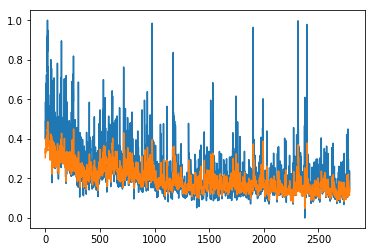

In [61]:
plt.plot(testY)
plt.plot(testPredict)
plt.show()